# 32-point 16-bit FFT Simulation

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# define some helpful functions:
def plot_complex(X, ax, title):
    """
    plot a complex variable `X` on axis `ax` with title `title`.
    """
    re = ax.plot(np.real(X), 'x-', label='real')
    im = ax.plot(np.imag(X), 'x-', label='imag')
    ax.legend()
    ax.set_title(title)
    return re, im

def to_int(hexstr, bits):
    """
    Convert `bits`-bit representation twos-complement hex string `hexstr` to an integer.   
    from https://stackoverflow.com/a/6727975/6115747.
    """
    value = int(hexstr, 16)
    if value & (1 << (bits - 1)):
        value -= 1 << bits
    return value

def int2hex(integer, digits):
    """
    Convert integer `integer` to `digits`-bit two's complement hex representation.
    """
    if integer >= 0:
        return hex(integer)[2:].zfill(digits)
    else:
        return hex(2**(4*digits) + integer)[2:]

# Generate test case `x`:

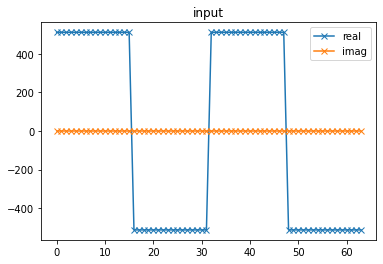

In [65]:
## square wave
x = np.concatenate((511*np.ones(16, dtype='int16'), -512*np.ones(16, dtype='int16'), 511*np.ones(16, dtype='int16'), -512*np.ones(16, dtype='int16')))

## all ones (DC)
# x = (2**10-1) * np.ones(32, dtype='int16')

## Cos wave
# x = ((2**10-1) * np.cos(np.arange(32)*2*np.pi/32)).astype('int16')

fig, ax = plt.subplots()
_ = plot_complex(x, ax, "input")

### write `x` to `simulation/modelsim/rom/test_in.memh`:
This is is the input file used by the testbench in ModelSim.

In [68]:
with open("test_in.memh", "w") as f:
    for sample in x:
        f.write(int2hex(int(np.real(sample)), 4) + int2hex(int(np.imag(sample)), 4) + "\n")

# Generate Ground Truth Output:
Both fixed-point and NumPy (floating point) ground-truth outputs are evaluated.

## Fixed-point (bit-accurate) FFT:

In [69]:
def fpFFT(x):
    """
    Fixed-point implementation of an FFT for N=64.
    The input to this needs to account for bit-growth (6 bits) for accurate results.
    """
    # reverse input data: 
    Data_i = np.zeros(x.shape, 'int16')
    Data_r = np.zeros(x.shape, 'int16')
    for i in range(64):
        Data_r[i] = int(np.real(x[int(f'{i:06b}'[::-1], 2)]))
        Data_i[i] = int(np.imag(x[int(f'{i:06b}'[::-1], 2)]))

    # generate twiddle factors:
    n = np.arange(64)
    w_re = np.cos(2*np.pi*n/64)
    Tw_r = (w_re * (2**(16-1) - 1)).astype('int')
    w_im = -np.sin(2*np.pi*n/64)
    Tw_i = (w_im * (2**(16-1) - 1)).astype('int')

    # perform FFT
    for i in range(6):
        for j in range(32):
            ja = j << 1
            jb = ja + 1
            ja = ((ja << i) | (ja >> (6-i))) & 0x3f # ; // Address A; 6 bit circular left shift
            jb = ((jb << i) | (jb >> (6-i))) & 0x3f # ; // Address B; implemented using C statements
            TwAddr = ((0xffffffe0 >> i) & 0x1f) & j

            # print(f"{i=}\t{j=}\t{ja=}\t{jb=}\t{TwAddr=}\t{Data_r[jb]=}\t{Data_i[jb]=}\t{Tw_r[TwAddr]=}\t{Tw_i[TwAddr]=}")
            temp_r = int(round((Data_r[jb] * Tw_r[TwAddr]) / 32768)) - int(round((Data_i[jb] * Tw_i[TwAddr]) / 32768))
            temp_i = int(round((Data_r[jb] * Tw_i[TwAddr]) / 32768)) + int(round((Data_i[jb] * Tw_r[TwAddr]) / 32768))
            # print(f"{temp_r=}, {temp_i=}")
            
            Data_r[jb] = Data_r[ja] - temp_r
            Data_i[jb] = Data_i[ja] - temp_i
            Data_r[ja] += temp_r
            Data_i[ja] += temp_i    
    return Data_r + 1j*Data_i

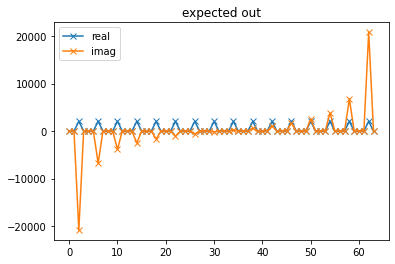

In [70]:
X = fpFFT(x)
fig, ax = plt.subplots()
_ = plot_complex(X, ax, "expected out")

## NumPy (floating point) FFT:

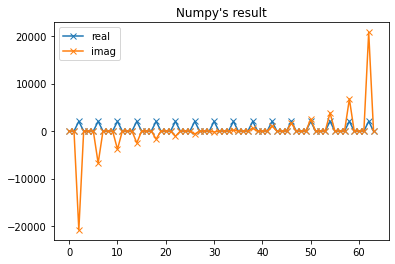

In [71]:
numpy_out = np.fft.fft(x)
fig, ax = plt.subplots()
_ = plot_complex(numpy_out, ax, "Numpy's result")

In [72]:
# note that due to fixed- vs. floating- point differences,
# numpy and our reference implementation yield slightly different results
numpy_out - X

array([ 0.+0.j        ,  0.+0.j        ,  0.+1.61338695j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.+0.24190451j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        , -1.-1.79677052j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.-0.05821335j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.-0.10880604j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  1.+0.39021584j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.+0.35268534j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.-0.51341127j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.+0.51341127j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.-0.35268534j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  1.-0.39021584j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.+0.10880604j,  0.+0.j        ,
        0.+0.j        ,  0.+0.j        ,  0.+0.05821335j,  0.+0.j        ,
        0.+0.j        ,  

### write to `simulation/modelsim/rom/gt_test_out.memh`:
This is the bit-accurate ground-truth output that the ModelSim testbench uses.

In [73]:
with open("gt_test_out.memh", "w") as f:
    for sample in X:
        f.write(int2hex(int(np.real(sample)), 4) + int2hex(int(np.imag(sample)), 4) + "\n")

# Evaluate the Hardware Implementation's output:
Note that the `fft_testbench` needs to be run to completion in modelsim in order to generate the file!

In [9]:
out = np.loadtxt("simulation/modelsim/rom/test_out.memh",
                 dtype='complex',
                 converters={0:lambda s: to_int(s[0:4], 16) + 1j*to_int(s[4:8], 16)})

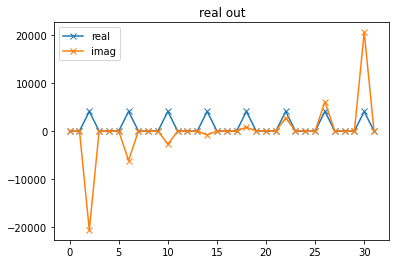

In [10]:
fig, ax = plt.subplots()
_ = plot_complex(out, ax, "real out")

## Compare Hardware and Python Fixed-Point Implementations:

In [11]:
X - out

array([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
       0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])

# Generate Figure:

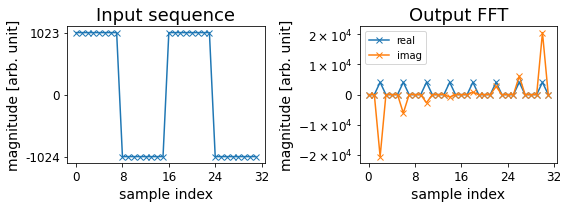

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
tsize = 18
lsize = 14
xsize = 12

axs[0].plot(x, 'x-')
axs[0].set_title("Input sequence", fontsize=tsize)
axs[0].set_xticks([0, 8, 16, 24, 32])
axs[0].set_xticklabels([0, 8, 16, 24, 32], fontsize=xsize)
axs[0].set_yticks([-1024, 0, 1023])
axs[0].set_yticklabels([-1024, 0, 1023], fontsize=xsize)
axs[0].set_xlabel("sample index", fontsize=lsize)
axs[0].set_ylabel("magnitude [arb. unit]", fontsize=lsize)

plot_complex(out, axs[1], "")
axs[1].set_title("Output FFT", fontsize=tsize)
axs[1].set_xlabel("sample index", fontsize=lsize)
axs[1].set_ylabel("magnitude [arb. unit]", fontsize=lsize)
axs[1].set_xticks([0, 8, 16, 24, 32])
axs[1].set_xticklabels([0, 8, 16, 24, 32], fontsize=xsize)
axs[1].set_yticks(     [-20000, -10000, 0, 10000, 20000])
axs[1].set_yticklabels([r"$-2 \times 10^4$", r"$-1 \times 10^4$", 
                        r"$0$", 
                        r"$1 \times 10^4$", r"$2 \times 10^4$"], fontsize=xsize)

plt.tight_layout()
plt.savefig('test_case.pdf')  